# Quad modelling notebook

With this notebook, we provide an example of how to model a quadrupoly lensed quasar lens with a host galaxy and a lens galaxy component.

We recommend to first go through the starting guide notebook, where the building blocks of *lenstronomy* are explained in detail.


*lenstronomy* comes with a set of neat features that facilitate the modelling of quad lenses. This notebook introduces those features and how to use them.

<div class="alert alert-warning">

**Warning:** This particular example below works only with a 4-imaged point source. If you play around with other lens models that predict another image multiplicity, there will be an error. Please have a look at other notebooks in re-configure the modelling in those cases.

</div>

<div class="alert alert-warning">

**Be aware:** The default option of lenstronomy is inferring the image magnitudes of the unresolved point sources independently of each other, meaning no potential knowledge about the lensing magnification at the image positions is used. The reason for it is, because stellar micro-lensing of the source by the lensing galaxy can introduce sufficient (de-)magnification that the model is not accounting for.
    We refer to the PointSource() class and the keyword 'fixed_magnification_list' to change the option.

</div>

In [1]:
# some python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF


## creating a mock image of a quad
We follow closely the starting guide in how we create a mock image with noise properties. In this example we use an elliptical power-law convergence profile with external shear as the lens model, two different Sersic profiles as the light components of the deflector and the quasar host galaxy and a HST-like resolution of the image.

In [2]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0, 0
# mass multiplier 
mass_multiplier = 1


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = 0, 0

# brightness of the source
source_brightness = 1

0.019601331556824832 0.003973386615901225


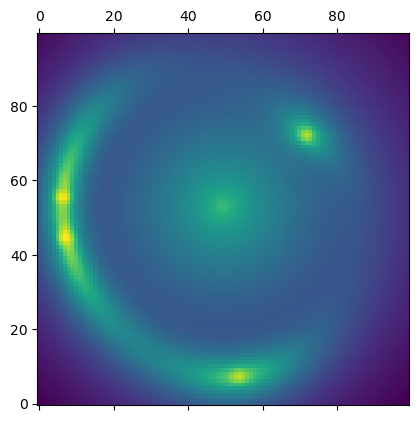

In [11]:

# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
print(gamma1, gamma2)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

### Q: print out the image positions and compare to the source. What is different here vs. in the doubly lensed quasar?

# CUSP

In [4]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0.5, 0.5
# mass multiplier 
mass_multiplier = 1


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = 0.4, 0.4

# brightness of the source
source_brightness = 1

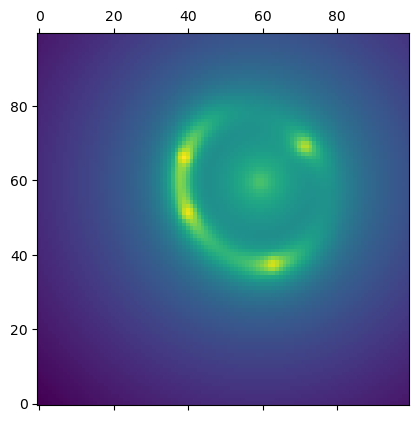

In [5]:

# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

/var/folders/2r/gwrt1nq934zd6xky7hbfb8_80000gn/T/ipykernel_73323/3564520624.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


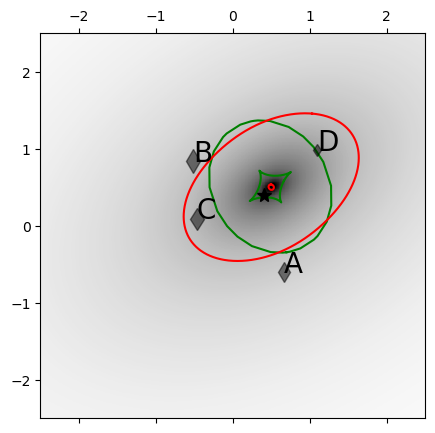

In [6]:

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
lensModel = LensModel(lens_model_list=lens_model_list)
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(ra_source, dec_source, kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=ra_source, sourcePos_y=dec_source, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

# CROSS

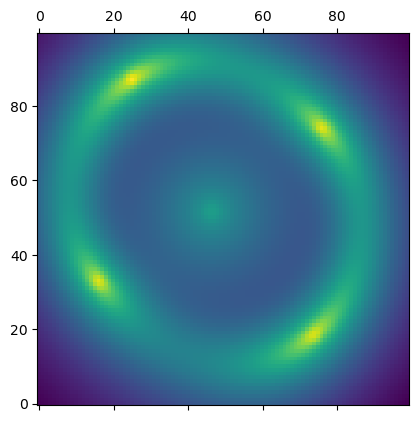

In [7]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = -0.15, 0.1
# mass multiplier 
mass_multiplier = 2


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = -0.1, 0.1

# brightness of the source
source_brightness = 10


# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

/var/folders/2r/gwrt1nq934zd6xky7hbfb8_80000gn/T/ipykernel_73323/3564520624.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


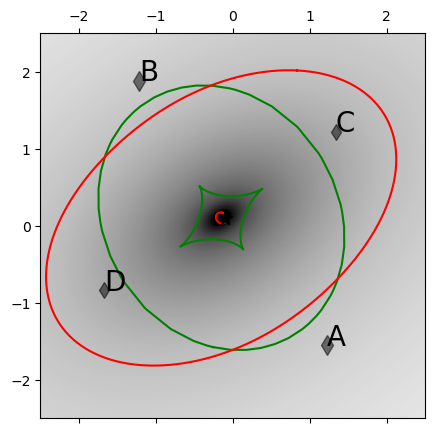

In [8]:

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
lensModel = LensModel(lens_model_list=lens_model_list)
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(ra_source, dec_source, kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=ra_source, sourcePos_y=dec_source, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

# CUSP 

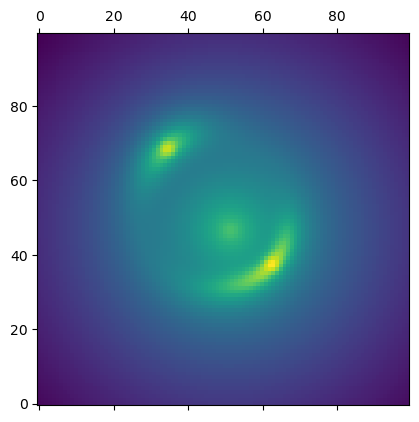

/var/folders/2r/gwrt1nq934zd6xky7hbfb8_80000gn/T/ipykernel_73323/4062804788.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


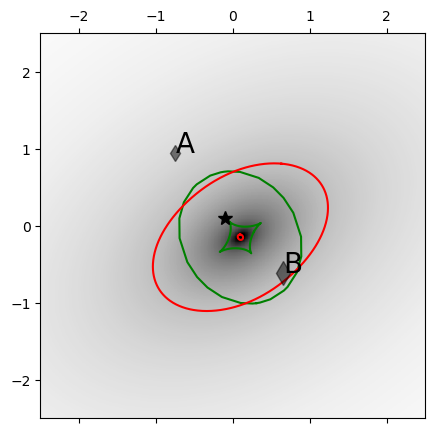

In [9]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0.1, -0.15
# mass multiplier 
mass_multiplier = 1


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = -0.1, 0.1

# brightness of the source
source_brightness = 1


# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

# plot the critical curves plots
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
lensModel = LensModel(lens_model_list=lens_model_list)
solver = LensEquationSolver(lensModel)


# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(ra_source, dec_source, kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=ra_source, sourcePos_y=dec_source, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

# FOLD 

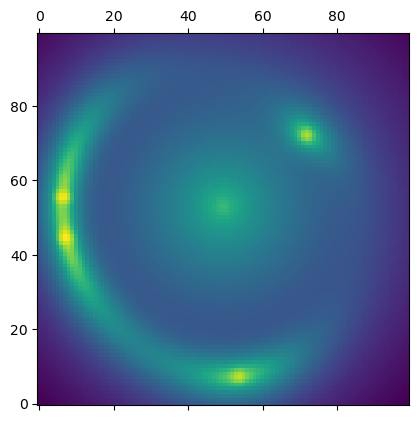

[ 0.21607842 -2.15109948 -2.10823036  1.12234096]


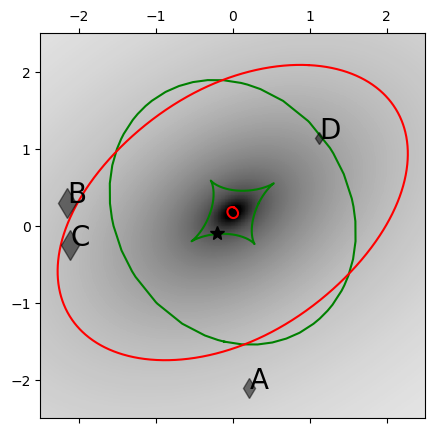

In [10]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0. , 0.17
# mass multiplier 
mass_multiplier = 2


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = -0.2, -0.1

# brightness of the source
source_brightness = 1


# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
lensModel = LensModel(lens_model_list=lens_model_list)
solver = LensEquationSolver(lensModel)


# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(ra_source, dec_source, kwargs_lens)
print(theta_ra)
# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=ra_source, sourcePos_y=dec_source, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
plt.show()